# **U-Net Model Training Notebook**

## **Overview:**
- Implements a **U-Net model** for **skin lesion segmentation** on the **ISIC 2018 dataset**.
- Uses **pretrained ResNet-34** as the encoder for feature extraction.
- The **decoder is trained from scratch** on the ISIC 2018 dataset for lesion segmentation.
- Optimized with **Dice + BCE loss** for better medical segmentation performance.
- Tracks **training & validation loss, Dice Score, and IoU** over multiple epochs.
- Saves the **best model** based on the highest Dice score.
- Provides **visualization of predictions** on test images for qualitative evaluation.

## **Metrics Used:**

- **Dice Score** (overlap between prediction and ground truth).
- **IoU (Intersection over Union)** for evaluating segmentation quality.
- **Training & Validation Loss** (to assess convergence and generalization).

## Step 1: Importing Libraries and Mounting Files from Google Drive

In [ ]:
!pip install torch torchvision torchaudio torchmetrics
!pip install timm==0.9.2
!pip install segmentation-models-pytorch

In [2]:
import torch
import timm
import segmentation_models_pytorch as smp

print("Torch version:", torch.__version__)
print("Timm version:", timm.__version__)
print("Segmentation Models PyTorch imported successfully!")

Torch version: 2.5.1+cu124
Timm version: 0.9.2
Segmentation Models PyTorch imported successfully!


In [3]:
import os
import numpy as np
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from google.colab import drive
import matplotlib.pyplot as plt

In [4]:
# Try to detect if running in Colab
IN_COLAB = "google.colab" in str(get_ipython())

# Define dataset path
if IN_COLAB:
    print("Running in Google Colab: Mounting Drive...")
    drive.mount('/content/drive')
    BASE_DIR = BASE_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset"
else:
    print("Running on a local machine: Set BASE_DIR manually!")
    BASE_DIR = "/path/to/local/dataset/processed_dataset"  # Change this when running locally

# Print the dataset directory
print(f"Dataset directory: {BASE_DIR}")

Running in Google Colab: Mounting Drive...
Mounted at /content/drive
Dataset directory: /content/drive/MyDrive/swinunet-medical-segmentation/dataset/processed_dataset


## Step 2: Verify GPU and Environment

In [5]:
print("GPU Available:", torch.cuda.is_available()) # checks if a GPU is accessible.

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Running on device:", device)

GPU Available: True
GPU Name: NVIDIA L4
Running on device: cuda


## Step 3: Define a PyTorch Dataset for Our Preprocessed .npy Files

Now we’ll create a custom Dataset class that reads our images and masks from the .npy files. This allows us to easily use DataLoader for batching and shuffling. (This is a common practice for PyTorch).

In [6]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None): # We load two .npy files (images & masks). Optionally store a transform if we want to apply augmentations later
        """
        images_path: Path to the .npy file containing image data (shape: (N, H, W, C))
        masks_path : Path to the .npy file containing mask data  (shape: (N, H, W))
        transform  : (Optional) Albumentations transform for on-the-fly augmentations
        """
        # 1. Load images and masks from disk
        self.images = np.load(images_path)  # shape: (N, H, W, C)
        self.masks  = np.load(masks_path)   # shape: (N, H, W)

        # 2. Store the transform if you want data augmentation later
        self.transform = transform

    def __len__(self): # Returns the total number of samples (len(self.images)). PyTorch’s DataLoader uses this to iterate
        """Return the total number of samples in this dataset."""
        return len(self.images)

    def __getitem__(self, idx): # Retrieves one (image, mask) pair at index idx
        """
        Retrieve the sample (image, mask) at index 'idx'.
        Apply optional augmentation transforms.
        Convert to PyTorch tensors if no transform is provided.
        """
        # 1. Get the raw numpy image and mask
        image = self.images[idx]  # shape: (H, W, C)
        mask  = self.masks[idx]   # shape: (H, W)

        # 2. If we have an Albumentations transform, apply it
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]  # Already a torch tensor if using ToTensorV2
            mask  = augmented["mask"]
        else:
            # Convert to PyTorch tensors manually
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask  = torch.from_numpy(mask).long()

        # 3. Return the processed image and mask
        return image, mask

Note: We store a transform if we want to do random flips, rotations, etc. If you don’t have any transforms yet, it stays None—i.e. no augmentations.

## Step 4: Create a DataLoader for Training & Validation

Now that we have our ISICDataset class defined, let’s set up the DataLoader. This allows us to:

1.	Batch our images and masks (e.g., batches of size 8).
2.	Shuffle the data for training.
3.	Potentially use multiple workers to speed up data loading.

In [7]:
# 1. Specify the paths to your .npy files
train_images_path = f"{BASE_DIR}/train_images.npy"
train_masks_path  = f"{BASE_DIR}/train_masks.npy"
val_images_path   = f"{BASE_DIR}/val_images.npy"
val_masks_path    = f"{BASE_DIR}/val_masks.npy"
test_images_path  = f"{BASE_DIR}/test_images.npy"  # Added test images
test_masks_path   = f"{BASE_DIR}/test_masks.npy"   # Added test masks

# 2. Instantiate your dataset objects
train_dataset = ISICDataset(
    images_path=train_images_path,
    masks_path=train_masks_path,
    transform=None  # We'll add augmentation transforms later if desired
)

val_dataset = ISICDataset(
    images_path=val_images_path,
    masks_path=val_masks_path,
    transform=None
)

test_dataset = ISICDataset(  # Added test dataset
    images_path=test_images_path,
    masks_path=test_masks_path,
    transform=None
)

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

# 4. Quick test: check shapes of a single batch
train_batch = next(iter(train_loader))
images, masks = train_batch
print("Images batch shape:", images.shape)
print("Masks batch shape:", masks.shape)

# Test that test dataset is properly loaded
test_batch = next(iter(test_loader))
test_images, test_masks = test_batch
print("Test Images batch shape:", test_images.shape)
print("Test Masks batch shape:", test_masks.shape)

Images batch shape: torch.Size([8, 3, 256, 256])
Masks batch shape: torch.Size([8, 256, 256])
Test Images batch shape: torch.Size([8, 3, 256, 256])
Test Masks batch shape: torch.Size([8, 256, 256])


## Step 5: Define the Baseline U-Net Model

In this step, we define a U-Net model using the segmentation_models_pytorch (SMP) library.
U-Net is a widely used architecture for medical image segmentation because of its encoder-decoder structure that effectively captures both global context and fine-grained details.

There are several reasons why we use U-net first instead of Swin-Unet:

1.	Simpler Debugging: U-Net is easier to work with and helps verify that the dataset and training loop work correctly.
2.	Shorter Training Time: U-Net trains faster, making it a good baseline before moving on to advanced models like Swin-Unet.
3.	Modular Approach: Once the pipeline works with U-Net, we can swap it with Swin-Unet with minimal changes.

In [8]:
# Automatically detect and set device (GPU or CPU)
# This ensures the model runs optimally without needing manual changes.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define U-Net model
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

# Print model summary
print(model)

# Count model parameters (Insert this block right here)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 405MB/s]


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Step 6: Test U-Net Model on a Single Batch

Before we dive into training, we want to verify that our model is working correctly by running it on a single batch of images. This helps us catch potential issues before we begin full-scale training.

Motivation:

1.	Ensures the model is compatible with the input data.
2.	Confirms that the input and output shapes are correct.
3.	Identifies potential errors early, preventing time wastage during training.

In [9]:
# Move a batch of images to the correct device
images, masks = next(iter(train_loader))  # Get a single batch
images = images.to(device)

# Forward pass through the model
outputs = model(images)

# Print output shape
print("U-Net output shape:", outputs.shape)

U-Net output shape: torch.Size([8, 1, 256, 256])


Note:

You might be thinking why the U-Net output has only 1 channel ([8, 1, 256, 256]). For couple of reasons:

1.	U-Net is a segmentation model, meaning its goal is to output a probability map where each pixel corresponds to a segmentation class.
2.	In binary segmentation (like lesion vs. background), the output needs only one probability per pixel.
3.	This is why the model outputs a single-channel mask, where values close to 1 represent the object (lesion), and values close to 0 represent the background.
4.	Thus, the output shape is (batch_size=8, channels=1, height=256, width=256).

## Step 7: Define the Loss Function

For binary segmentation (lesion vs. background), we need a loss function that effectively measures how well the predicted masks match the ground truth. For this project, we will be using Dice Loss, which is a common choice for medical segmentation tasks.

In [10]:
# Define loss functions.
# We combine Dice Loss (good for segmentation) with BCEWithLogitsLoss for pixel-wise classification.
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(y_pred, y_true):
    # Ensure we are working with the correct tensor format
    if isinstance(y_pred, (list, tuple)):
        y_pred = y_pred[0]  # Extract first tensor if model outputs a list

    return 0.5 * bce_loss(y_pred, y_true) + 0.5 * dice_loss(y_pred, y_true)

# %% [code]
# **Corrected Metric Definitions**
dice_metric = torchmetrics.Dice(num_classes=1, multiclass=False, threshold=0.5).to(device)
iou_metric  = torchmetrics.JaccardIndex(task="binary").to(device)

# Quick test: Check loss computation for one batch
y_pred = model(images)  # Forward pass

# Reshape masks to have a channel dimension (add 1 at dim=1) and convert to float
# unsqueeze(1) adds the missing channel dimension to masks, making it [8, 1, 256, 256], which matches the model output
masks = masks.unsqueeze(1).float().to(device)

# Compute loss
loss = combined_loss(y_pred, masks)
print(f"Loss for this batch: {loss.item():.4f}")

Loss for this batch: 0.9251


## Step 8: Define the Optimizer

We’ll use AdamW as our optimizer, which is commonly used in deep learning due to its adaptive learning rate and efficiency.

In [11]:
# Define optimizer (AdamW preferred for better regularization and consistency)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",     # Monitor a metric you want to minimize (usually validation loss)
    factor=0.5,     # Multiply learning rate by this factor when improvement stalls
    patience=2,     # Wait for 2 epochs before reducing the LR (if no improvement)
    verbose=True    # Print message when LR is reduced
)

print("Optimizer and scheduler initialized successfully with AdamW!")

Optimizer and scheduler initialized successfully with AdamW!


## Step 9: Implement Training and Validation Loops

In [12]:
def train_one_epoch(model, train_loader, optimizer, loss_fn, dice_metric, iou_metric, scaler, device):
    model.train()
    running_loss, running_dice, running_iou = 0.0, 0.0, 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.unsqueeze(1).float().to(device)

        optimizer.zero_grad()

        # Forward pass with Mixed Precision
        with torch.amp.autocast(device_type="cuda"):
            preds = model(images)
            if isinstance(preds, (list, tuple)):
                preds = preds[0]
            loss = loss_fn(preds, masks)

        # Backward pass with GradScaler (MPT)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Calculate metrics
        preds = torch.sigmoid(preds)
        pred_binary = (preds > 0.5).int()
        running_dice += dice_metric(pred_binary, masks.int()).item()
        running_iou += iou_metric(pred_binary, masks.int()).item()

    return (
        running_loss / len(train_loader),
        running_dice / len(train_loader),
        running_iou / len(train_loader),
    )


def validate_one_epoch(model, val_loader, loss_fn, dice_metric, iou_metric, device):
    model.eval()
    val_loss, val_dice, val_iou = 0.0, 0.0, 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.unsqueeze(1).float().to(device)

            # Forward pass (MPT optional for validation, but recommended)
            with torch.amp.autocast(device_type="cuda"):
                preds = model(images)
                if isinstance(preds, (list, tuple)):
                    preds = preds[0]
                loss = loss_fn(preds, masks)

            val_loss += loss.item()

            # Calculate metrics
            preds = torch.sigmoid(preds)
            pred_binary = (preds > 0.5).int()
            val_dice += dice_metric(pred_binary, masks.int()).item()
            val_iou += iou_metric(pred_binary, masks.int()).item()

    return (
        val_loss / len(val_loader),
        val_dice / len(val_loader),
        val_iou / len(val_loader),
    )

Now that the training and validation functions are defined, the next step is to train the model over multiple epochs while tracking performance.

This loop will:

1.	Train the model on the training dataset.
2.	Validate the model after each epoch.
3.	Save the model if the dice score improves.

In [13]:
# Initialize GradScaler for Mixed Precision Training
scaler = torch.amp.GradScaler()

# Lists to store loss and metric history
train_losses, val_losses = [], []
train_dice_scores, val_dice_scores = [], []
train_iou_scores, val_iou_scores = [], []

# Set epochs and early stopping patience
num_epochs = 25
patience = 4
best_val_dice = 0.0
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Train and validate using previously defined functions
    train_loss, train_dice, train_iou = train_one_epoch(
        model, train_loader, optimizer, combined_loss, dice_metric, iou_metric, scaler, device
    )

    val_loss, val_dice, val_iou = validate_one_epoch(
        model, val_loader, combined_loss, dice_metric, iou_metric, device
    )

    # Append metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dice_scores.append(train_dice)
    val_dice_scores.append(val_dice)
    train_iou_scores.append(train_iou)
    val_iou_scores.append(val_iou)

    print(f"Epoch [{epoch+1}/{num_epochs}]: "
          f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
          f"Train Dice={train_dice:.4f}, Val Dice={val_dice:.4f}, "
          f"Train IoU={train_iou:.4f}, Val IoU={val_iou:.4f}")

    # Early stopping logic based on validation Dice
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), "best_unet.pth")
        print(f">>> Best model saved based on Dice Score: {val_dice:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered after epoch {epoch + 1}")
        break

    # Step LR scheduler
    scheduler.step(val_loss)

Epoch [1/25]: Train Loss=0.3543, Val Loss=0.2662, Train Dice=0.7981, Val Dice=0.8385, Train IoU=0.6819, Val IoU=0.7264
>>> Best model saved based on Dice Score: 0.8385
Epoch [2/25]: Train Loss=0.1859, Val Loss=0.1971, Train Dice=0.8886, Val Dice=0.8680, Train IoU=0.8029, Val IoU=0.7712
>>> Best model saved based on Dice Score: 0.8680
Epoch [3/25]: Train Loss=0.1387, Val Loss=0.1834, Train Dice=0.9042, Val Dice=0.8674, Train IoU=0.8279, Val IoU=0.7703
No improvement for 1 epochs.
Epoch [4/25]: Train Loss=0.1090, Val Loss=0.1505, Train Dice=0.9192, Val Dice=0.8880, Train IoU=0.8524, Val IoU=0.8014
>>> Best model saved based on Dice Score: 0.8880
Epoch [5/25]: Train Loss=0.0988, Val Loss=0.1360, Train Dice=0.9232, Val Dice=0.8985, Train IoU=0.8589, Val IoU=0.8182
>>> Best model saved based on Dice Score: 0.8985
Epoch [6/25]: Train Loss=0.0862, Val Loss=0.1590, Train Dice=0.9318, Val Dice=0.8845, Train IoU=0.8734, Val IoU=0.7971
No improvement for 1 epochs.
Epoch [7/25]: Train Loss=0.0798,

## Step 10: Load the Best Model

During training, we saved the best model (with the lowest validation loss) as "best_unet.pth". Now, we need to load that model so we can evaluate it on unseen data.

In [14]:
# Load the best saved model
best_model = smp.Unet(
    encoder_name="resnet34",  # Ensure the same architecture as training
    encoder_weights="imagenet",
    in_channels=3,  # Our input images have 3 color channels (RGB)
    classes=1,  # Binary segmentation (lesion vs. background)
)

# Load the saved weights
best_model.load_state_dict(torch.load("best_unet.pth"))

# Move model to GPU/CPU
best_model.to(device)

# Set model to evaluation mode (important for inference)
best_model.eval()

print("Best trained U-Net model loaded successfully!")

Best trained U-Net model loaded successfully!


<ipython-input-14-2304703d0ab0>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_unet.pth"))


Explanation of the preceding step:


1.	We recreate the U-Net model using the same architecture used in training.
2.	We load the saved model weights (.pth file), which contains the trained parameters.
3.	We move the model to the appropriate device (CPU/GPU).
4.	We set model.eval() because this turns off dropout and batch normalization updates, ensuring consistent predictions during inference.

## Step 11: Plotting Losses, Dice Scores, and IoU Scores Over Epochs

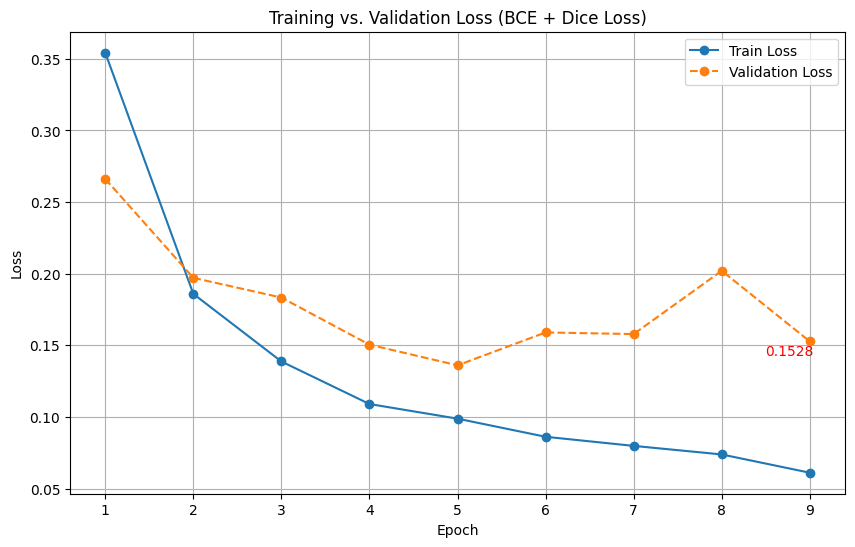

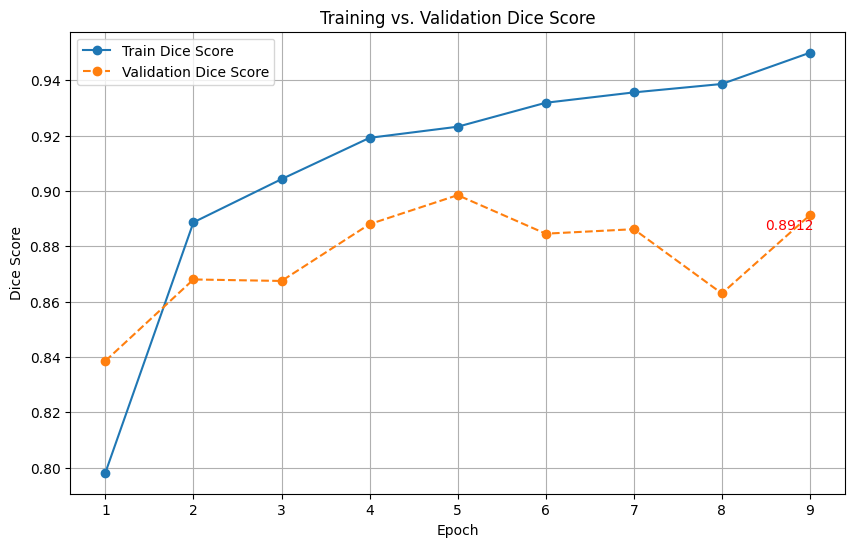

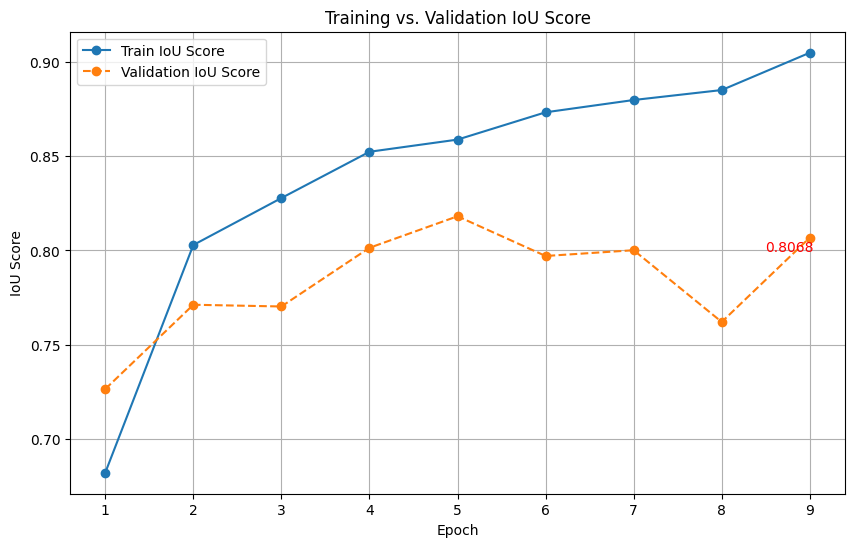

In [15]:
# Define the epoch range
epochs = range(1, len(train_losses) + 1)

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', linestyle='-', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', linestyle='--', label='Validation Loss')
plt.title('Training vs. Validation Loss (BCE + Dice Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_losses[-1]:.4f}", (epochs[-1], val_losses[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

# Plot Training vs Validation Dice Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_dice_scores, marker='o', linestyle='-', label='Train Dice Score')
plt.plot(epochs, val_dice_scores, marker='o', linestyle='--', label='Validation Dice Score')
plt.title('Training vs. Validation Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_dice_scores[-1]:.4f}", (epochs[-1], val_dice_scores[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

# Plot Training vs Validation IoU Score
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_iou_scores, marker='o', linestyle='-', label='Train IoU Score')
plt.plot(epochs, val_iou_scores, marker='o', linestyle='--', label='Validation IoU Score')
plt.title('Training vs. Validation IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.grid(True)
plt.annotate(f"{val_iou_scores[-1]:.4f}", (epochs[-1], val_iou_scores[-1]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=10, color='red')
plt.show()

## Step 12: Pick Random Test Images for Visualization

In [16]:
# 1. Specify the paths to your test images and masks
test_images_path = f"{BASE_DIR}/test_images.npy"
test_masks_path  = f"{BASE_DIR}/test_masks.npy"

# 2. Instantiate the test dataset
test_dataset = ISICDataset(
    images_path=test_images_path,
    masks_path=test_masks_path,
    transform=None  # No augmentation for testing
)

# Quick check
print(f"Test dataset size: {len(test_dataset)} samples")

Test dataset size: 1000 samples


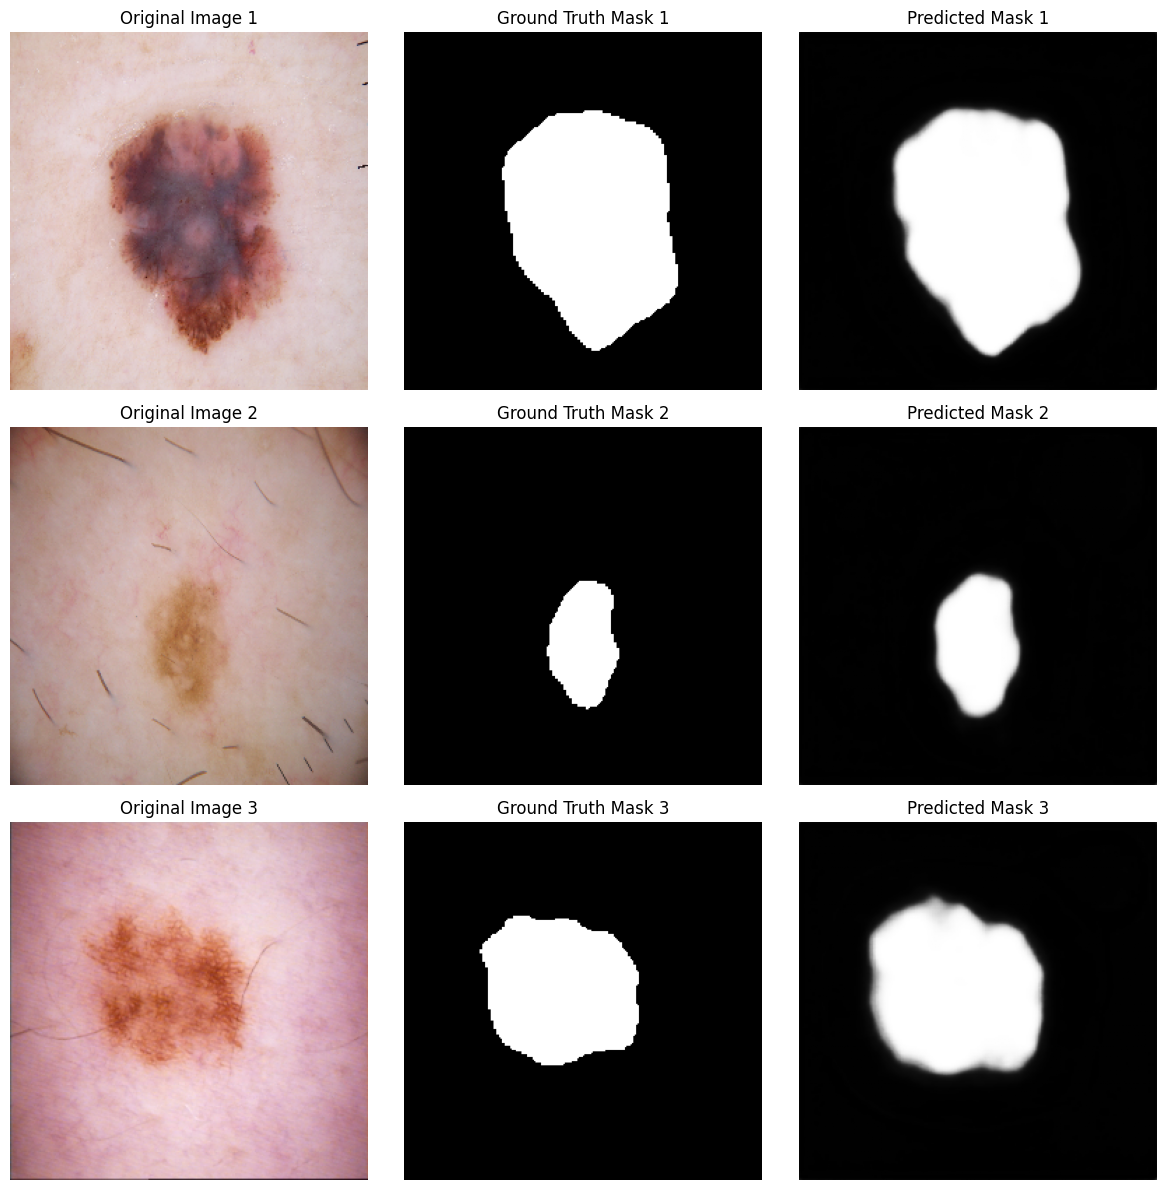

In [18]:
# Pick three random test samples
random_indices = random.sample(range(len(test_dataset)), 3)  # Select 3 random indices
selected_images = []
selected_masks = []
selected_preds = []

# Process each selected image
for idx in random_indices:
    image, mask = test_dataset[idx]  # Load image & mask from test dataset
    image_tensor = image.unsqueeze(0).to(device)  # Convert to batch format

    # Get model prediction
    with torch.no_grad():
        pred_mask = best_model(image_tensor)  # Forward pass
        pred_mask = torch.sigmoid(pred_mask)  # Apply sigmoid activation
        pred_mask = pred_mask.squeeze().cpu().numpy()  # Remove batch & move to CPU

    # Convert original image & mask to NumPy for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()  # Change shape from (C, H, W) → (H, W, C)
    mask_np = mask.cpu().numpy()  # Convert ground truth mask to NumPy

    # Store images for plotting
    selected_images.append(image_np)
    selected_masks.append(mask_np)
    selected_preds.append(pred_mask)

# 6. Plot images side by side
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):
    axes[i, 0].imshow(selected_images[i])
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(selected_masks[i], cmap="gray")
    axes[i, 1].set_title(f"Ground Truth Mask {i+1}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(selected_preds[i], cmap="gray")
    axes[i, 2].set_title(f"Predicted Mask {i+1}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

## Step 13: Compute Evaluation Metrics

Now that we have visually inspected the model’s predictions, the next step is to quantitatively evaluate its performance. We’ll compute common segmentation metrics:
1.	Dice Coefficient (F1 Score for Segmentation) – Measures the overlap between the predicted and ground truth masks.
2.	Intersection over Union (IoU/Jaccard Index) – Measures how well the predicted mask matches the true mask.
3.	Pixel Accuracy – Measures the percentage of correctly predicted pixels.

In [19]:
# Define metric functions (explicitly set `num_classes=2`)
dice_metric = torchmetrics.Dice(num_classes=2, threshold=0.5, average="micro").to(device)
iou_metric = torchmetrics.JaccardIndex(num_classes=2, task="binary").to(device)

# Convert NumPy arrays back to PyTorch tensors before thresholding
pred_mask_tensor = torch.tensor(pred_mask).to(device)
mask_tensor = torch.tensor(mask).to(device)

# Convert tensors to binary masks
pred_binary = (pred_mask_tensor > 0.5).int()  # Convert predictions to int
mask_binary = (mask_tensor > 0.5).int()  # Convert ground truth mask to int

# Compute Dice and IoU scores
dice_score = dice_metric(pred_binary, mask_binary)
iou_score = iou_metric(pred_binary, mask_binary)

print(f"Dice Score: {dice_score.item():.4f}")
print(f"IoU Score: {iou_score.item():.4f}")

Dice Score: 0.9564
IoU Score: 0.7698


<ipython-input-19-41a54100b11b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_tensor = torch.tensor(mask).to(device)


## Step 14: Evaluating the Entire Test Set

In [20]:
# Run evaluation on the entire test set
best_model.eval()  # Ensure model is in evaluation mode

test_dice, test_iou = 0.0, 0.0
num_samples = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        preds = best_model(images)
        preds = torch.sigmoid(preds)  # Convert logits to probabilities
        pred_binary = (preds > 0.5).int()  # Binarize predictions

        # Compute Dice & IoU
        test_dice += dice_metric(pred_binary, masks.unsqueeze(1).int()).item()
        test_iou += iou_metric(pred_binary, masks.unsqueeze(1).int()).item()
        num_samples += 1

# Compute average metrics
test_dice /= num_samples
test_iou /= num_samples

print(f"Final Test Dice Score: {test_dice:.4f}")
print(f"Final Test IoU Score: {test_iou:.4f}")

Final Test Dice Score: 0.9341
Final Test IoU Score: 0.7939


## Step 15: Saving the Model In Google Drive

In [21]:
# Define model save path
MODEL_DIR = "/content/drive/MyDrive/swinunet-medical-segmentation/models"

# Ensure the directory exists
os.makedirs(MODEL_DIR, exist_ok=True)

# Copy best model to Google Drive (inside models folder)
!cp best_unet.pth {MODEL_DIR}/best_unet.pth
print(f"Model saved to: {MODEL_DIR}/best_unet.pth")

Model saved to: /content/drive/MyDrive/swinunet-medical-segmentation/models/best_unet.pth


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
